In [19]:
from pathlib import Path
import os

def find_project_root(start: Path | None = None) -> Path:
    """
    Walk upward from `start` (or current working dir) until we find a directory
    that contains either `.git` or `pyproject.toml`. If nothing is found, raise.
    """
    if start is None:
        # In notebooks, __file__ is typically undefined; use CWD safely.
        start = Path.cwd()
    start = start if start.is_dir() else start.parent

    for p in [start, *start.parents]:
        if (p / ".git").exists() or (p / "pyproject.toml").exists():
            return p
    raise RuntimeError(
        f"Could not locate project root above {start}. "
        "Open the notebook from inside the repo or set PROJECT_ROOT env var."
    )

# One-time project root detection per session
if "FIT_PROTEINS_PROJECT_ROOT" in os.environ:
    project_root = Path(os.environ["FIT_PROTEINS_PROJECT_ROOT"]).resolve()
else:
    project_root = find_project_root()
    os.environ["FIT_PROTEINS_PROJECT_ROOT"] = str(project_root)

# Only chdir if not already there (prevents 'creeping upwards' on re-runs)
if Path.cwd().resolve() != project_root:
    os.chdir(project_root)

print("Project root:", project_root)
print("Data dirs exist:",
      (project_root / "data/raw").exists(),
      (project_root / "data/processed").exists())

# Define paths you’ll reuse below
DATA_DIR = project_root / "data/processed"
RAW_DIR  = project_root / "data/raw"



Project root: /Users/fut_payi/Desktop/F.I.T-Proteins
Data dirs exist: True True


In [20]:
train = pd.read_parquet(RAW_DIR / "train_brd4_50k_stratified.parquet")
test  = pd.read_parquet(RAW_DIR / "test_brd4_50k.parquet")

print("Train shape:", train.shape)
train.head()


Train shape: (50000, 7)


id protein_name                                    molecule_smiles  \
0    9051         BRD4  C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCOCC(=C)C)nc(Nc...   
1   71760         BRD4  C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCC2OCCC2(C)C)nc...   
2   92688         BRD4  C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCC(C)(O)CC)nc(N...   
3  120681         BRD4  C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCCCOCC)nc(NCC2CC...   
4   39303         BRD4  C#CC[C@@H](CC(=O)N[Dy])Nc1nc(NCc2nnc(C(C)(C)C)...   

                             buildingblock1_smiles   buildingblock2_smiles  \
0  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21          C=C(C)COCCN.Cl   
1  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21          CC1(C)CCOC1CCN   
2  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21            CCC(C)(O)CCN   
3  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21                 CCOCCCN   
4  C#CC[C@@H](CC(=O)O)NC(=O)OCC1c2ccccc2-c2ccccc21  CC(C)(C)c1nnc(CN)s1.Cl   

  buildingblock3_smiles  binds  
0           COc1ncccc1N      0  
1  CC(CN)c1c(Cl)cccc1Cl      0  
2         Nc1cc(Br)ccn1      0  
3         Cl.NCC1CCCOC1      0  
4  Nc1ccnc(-c2ccccc2)c1      0

/var/folders/z4/nl4m_8q17pxg6zl3ln3klpq00000gn/T/ipykernel_25548/3097738029.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


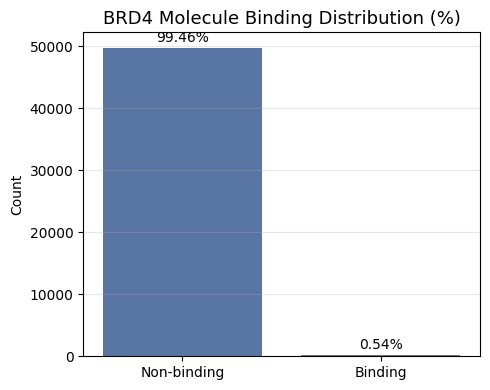

✅ Binding fraction: 0.00538  (0.54% positive examples)


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count positives and negatives
bind_counts = train["binds"].value_counts().sort_index()

plt.figure(figsize=(5, 4))
ax = sns.barplot(
    x=bind_counts.index.map({0: "Non-binding", 1: "Binding"}),
    y=bind_counts.values,
    palette=["#4C72B0", "#C44E52"]
)

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,
        height + (0.01 * max(bind_counts.values)),
        f"{height / bind_counts.sum() * 100:.2f}%",
        ha="center", va="bottom", fontsize=10
    )
plt.title("BRD4 Molecule Binding Distribution (%)", fontsize=13)
plt.ylabel("Count")
plt.xlabel("")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Print precise ratio
pos_frac = train["binds"].mean()
print(f"✅ Binding fraction: {pos_frac:.5f}  ({pos_frac*100:.2f}% positive examples)")



In [24]:
from pathlib import Path
from scipy.sparse import load_npz
import numpy as np
import joblib

PROCESSED_DIR = Path("data/processed")

X_train = load_npz(PROCESSED_DIR / "X_train_full.npz")
y_train = np.load(PROCESSED_DIR / "y_train_full.npy")
ids_train = np.load(PROCESSED_DIR / "ids_train_full.npy")
meta = joblib.load(PROCESSED_DIR / "prep_metadata.joblib")["meta"]

print("✅ Loaded processed data")
print("X_train:", X_train.shape)
print("y_train positives:", y_train.sum(), "/", len(y_train), f"({y_train.mean():.5f})")
print("Feature density:", X_train.count_nonzero() / (X_train.shape[0]*X_train.shape[1]))
print("Metadata:", meta)


✅ Loaded processed data
X_train: (50000, 262145)
y_train positives: 269 / 50000 (0.00538)
Feature density: 0.0009426195426195426
Metadata: {'hash_n_features': 262144, 'ngram_range': (2, 4), 'train_path': '/Users/fut_payi/Desktop/F.I.T-Proteins/data/raw/train_brd4_50k_stratified.parquet', 'feature_blocks': ['hashed_smiles', 'onehot_protein']}


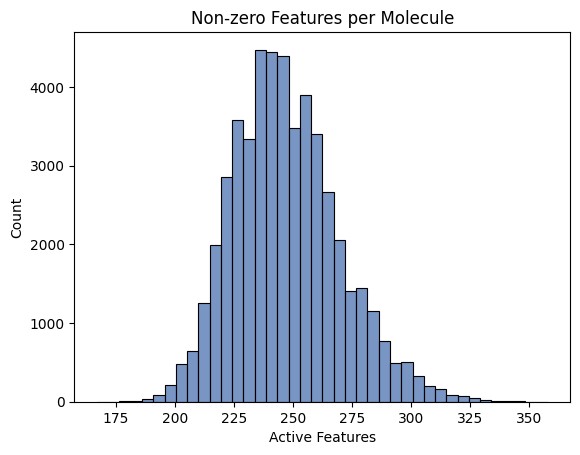

Median non-zero features per molecule: 245.0


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

nz_per_row = X_train.getnnz(axis=1)
sns.histplot(nz_per_row, bins=40, kde=False, color="#4C72B0")
plt.title("Non-zero Features per Molecule")
plt.xlabel("Active Features")
plt.ylabel("Count")
plt.show()

print(f"Median non-zero features per molecule: {np.median(nz_per_row)}")


/var/folders/z4/nl4m_8q17pxg6zl3ln3klpq00000gn/T/ipykernel_25548/3447410108.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="binds", y="nonzero", data=df_summary, palette=["#4C72B0", "#C44E52"])


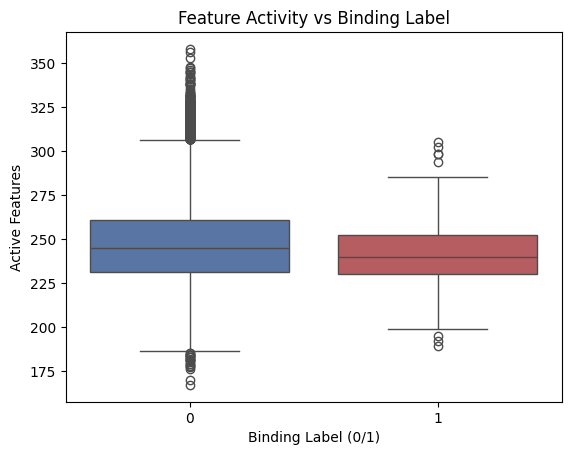

In [26]:
import pandas as pd

df_summary = pd.DataFrame({"binds": y_train, "nonzero": nz_per_row})
sns.boxplot(x="binds", y="nonzero", data=df_summary, palette=["#4C72B0", "#C44E52"])
plt.title("Feature Activity vs Binding Label")
plt.xlabel("Binding Label (0/1)")
plt.ylabel("Active Features")
plt.show()


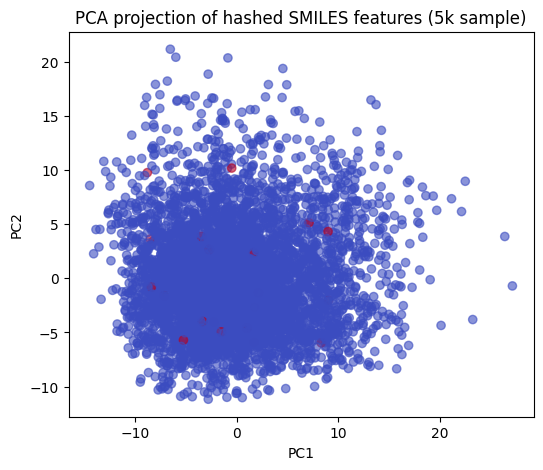

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
X_sample = X_train[:5000].toarray()  # small subset for visualization
y_sample = y_train[:5000]

X_pca = pca.fit_transform(X_sample)
plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_sample, cmap="coolwarm", alpha=0.6)
plt.title("PCA projection of hashed SMILES features (5k sample)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score

logreg = LogisticRegression(
    penalty="l2", solver="saga", max_iter=2000, n_jobs=-1, class_weight="balanced"
)
logreg.fit(X_train, y_train)

y_pred_proba = logreg.predict_proba(X_train)[:,1]
print("AUPRC:", average_precision_score(y_train, y_pred_proba))
print("AUROC:", roc_auc_score(y_train, y_pred_proba))


AUPRC: 0.2824733449622449
AUROC: 0.9927370965833358


/Users/fut_payi/Downloads/anaconda3/envs/fit-proteins/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


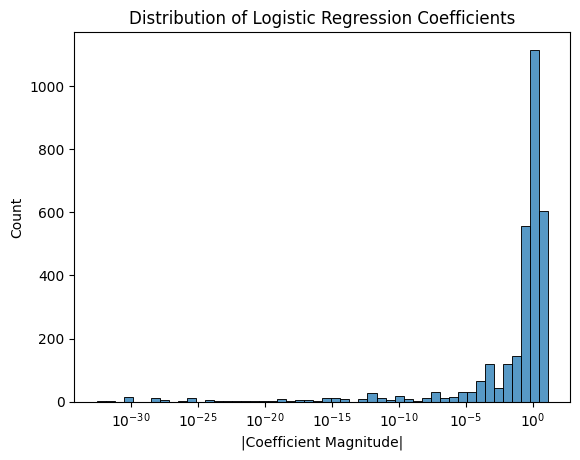

In [29]:
coef_mags = np.abs(logreg.coef_).flatten()
sns.histplot(coef_mags, bins=50, log_scale=True)
plt.title("Distribution of Logistic Regression Coefficients")
plt.xlabel("|Coefficient Magnitude|")
plt.show()
